# Classification

In [1]:
include("utils.jl"); using .Utils
checkpkgs("CSV", "DataFrames", "Plots", "Statistics", "Distributions")

getfile("https://github.com/allisonhorst/palmerpenguins/raw/master/inst/extdata/penguins_raw.csv")

## Penguin Data

In [2]:
import CSV
using DataFrames, Statistics, Plots

df = DataFrame(CSV.File("penguins_raw.csv"; missingstring="NA"))
size(df)

(344, 17)

In [3]:
first(df, 5)

,studyName,Sample Number,Species,Region,Island
,String,Int64,String,String,String
1,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen
2,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen
3,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen
4,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen
5,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen


In [4]:
shorten(species) = split(species)[1]

transform!(df, "Species" => (x -> shorten.(x)) => "Species2");

In [5]:
include("empiricaldist.jl"); using .EmpiricalDist

"""Make a CDF for each species."""
function make_cdf_map(df, colname, by="Species2")
    cdf_map = Dict()
    grouped = groupby(df, by)
    for (k, group) in pairs(grouped)
        species = k[by]
        col = collect(skipmissing(group[!, colname])) # skip missing values
        cdf_map[species] = cdffromseq(col, name=species)
    end
    return cdf_map
end

make_cdf_map

In [6]:
"""
Make a CDF for each species.

df: DataFrame
colname: string column name
by: string column name

returns: dictionary from species name to Cdf
"""
function plot_cdfs(df, colname, by="Species2")
    cdf_map = make_cdf_map(df, colname, by)
    plot()
    for (species, cdf) in pairs(cdf_map)
        plot!(cdf, label=species)
    end
    
    xlabel!(colname)
    ylabel!("CDF")
    plot!(legend=:topleft)
end

plot_cdfs

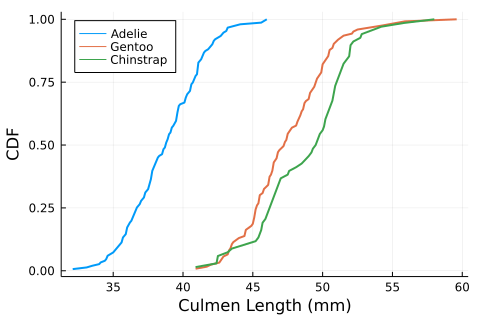

In [7]:
colname = "Culmen Length (mm)"
plot_cdfs(df, colname)

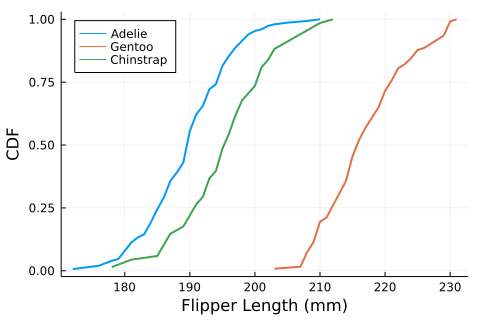

In [8]:
colname = "Flipper Length (mm)"
plot_cdfs(df, colname)

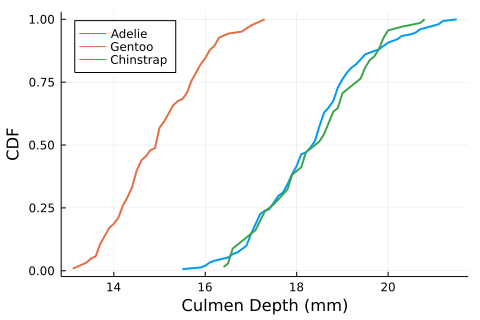

In [9]:
colname = "Culmen Depth (mm)"
plot_cdfs(df, colname)

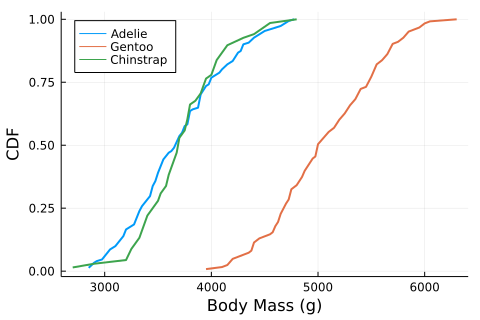

In [10]:
colname = "Body Mass (g)"
plot_cdfs(df, colname)

## Normal Models

In [11]:
using Statistics, Distributions

"""Make a map from species to norm object."""
function make_norm_map(df, colname, by="Species2")
    norm_map = Dict()
    
    grouped = groupby(df, by)
    for (k, group) in pairs(grouped)
        species = k[by]
        col = collect(skipmissing(group[!, colname])) # skip missing values
        μ = mean(col)
        σ = std(col)
        norm_map[species] = Normal(μ, σ)
    end
    return norm_map
end
make_norm_map(df, colname; by="Species2") = make_norm_map(df, colname, by)

make_norm_map (generic function with 2 methods)

In [12]:
flipper_map = make_norm_map(df, "Flipper Length (mm)")
keys(flipper_map)

KeySet for a Dict{Any, Any} with 3 entries. Keys:
  "Adelie"
  "Gentoo"
  "Chinstrap"

In [13]:
data = 193
pdf(flipper_map["Adelie"], data)

0.054732511875530694

In [14]:
hypos = keys(flipper_map)
likelihood = [pdf(flipper_map[hypo], data) for hypo in hypos]
likelihood

3-element Vector{Float64}:
 0.054732511875530694
 5.866045366199098e-5
 0.051721356158881626

## The Update

In [15]:
prior = Pmf(1/3, hypos)
prior

┌───────────┬──────────┐
│           │    probs │
├───────────┼──────────┤
│    Adelie │ 0.333333 │
│    Gentoo │ 0.333333 │
│ Chinstrap │ 0.333333 │
└───────────┴──────────┘


In [16]:
posterior = prior .* likelihood
normalize!(posterior)
posterior

┌───────────┬─────────────┐
│           │       probs │
├───────────┼─────────────┤
│    Adelie │     0.51386 │
│    Gentoo │ 0.000550738 │
│ Chinstrap │    0.485589 │
└───────────┴─────────────┘


In [17]:
"""Update hypothetical species."""
function update_penguin(prior, data, norm_map)
    hypos = prior.qs
    likelihood = [pdf(norm_map[hypo],data) for hypo in hypos]
    posterior = prior .* likelihood
    normalize!(posterior)
    return posterior
end

update_penguin

In [18]:
posterior1 = update_penguin(prior, 193, flipper_map)
posterior1

┌───────────┬─────────────┐
│           │       probs │
├───────────┼─────────────┤
│    Adelie │     0.51386 │
│    Gentoo │ 0.000550738 │
│ Chinstrap │    0.485589 │
└───────────┴─────────────┘


In [19]:
culmen_map = make_norm_map(df, "Culmen Length (mm)");

In [20]:
posterior2 = update_penguin(prior, 48, culmen_map)
posterior2

┌───────────┬────────────┐
│           │      probs │
├───────────┼────────────┤
│    Adelie │ 0.00155723 │
│    Gentoo │   0.523785 │
│ Chinstrap │   0.474658 │
└───────────┴────────────┘


## Naive Bayesian Classification

In [21]:
"""Naive Bayesian classifier

prior: Pmf
data_seq: sequence of measurements
norm_maps: sequence of maps from species to distribution

returns: Pmf representing the posterior distribution
"""
function update_naive(prior, data_seq, norm_maps)
    posterior = copy(prior)
    for (data, norm_map) in zip(data_seq, norm_maps)
        posterior = update_penguin(posterior, data, norm_map) # alow missing to propagate
    end
    return posterior
end

update_naive

In [22]:
colnames = ["Flipper Length (mm)", "Culmen Length (mm)"]
norm_maps = [flipper_map, culmen_map];

In [23]:
data_seq = 193, 48
posterior = update_naive(prior, data_seq, norm_maps)
posterior

┌───────────┬────────────┐
│           │      probs │
├───────────┼────────────┤
│    Adelie │ 0.00345541 │
│    Gentoo │ 0.00124566 │
│ Chinstrap │   0.995299 │
└───────────┴────────────┘


In [24]:
maxprob(posterior)

"Chinstrap"

In [25]:
transform!(df, 
    AsTable(colnames) =>
        ByRow(data_seq -> all(ismissing, data_seq) ? missing : # propagate missing
                maxprob(update_naive(prior, data_seq, norm_maps))) => "Classification");

In [26]:
nrow(df)

344

In [27]:
#valid = map(!ismissing, df[!, "Classification"])
#sum(valid)

nvalid = count(!ismissing, df[!, "Classification"])

342

In [28]:
same = df[!, "Species2"] .== df[!, "Classification"]
nsame = count(skipmissing(same))

324

In [29]:
"""Compute the accuracy of classification."""
function accuracy(df)
    nvalid = count(!ismissing, df[!, "Classification"])
    nsame = count(skipmissing(df[!, "Species2"] .== df[!, "Classification"]))
    return nsame / nvalid
end

accuracy

## Joint Distributions

In [30]:
"""Make a scatter plot."""
function scatterplot(df, var1, var2)
    grouped = groupby(df, "Species2")
    plot()
    for (k, g) in pairs(grouped)
        scatter!(g[!, var1],  g[!, var2], label=k["Species2"])
    end
    scatter!(legend=:bottomright, xlabel=var1, ylabel=var2)
end

scatterplot

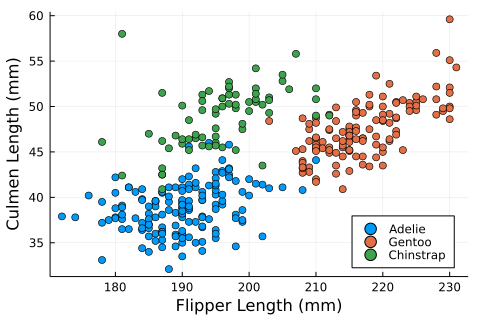

In [31]:
var1 = "Flipper Length (mm)"
var2 = "Culmen Length (mm)"
scatterplot(df, var1, var2)

In [32]:
"""Make a Pmf approximation to a normal distribution."""
function make_pmf_norm(dist, sigmas=3, n=101)
    μ, σ = mean(dist), std(dist)
    low = μ - sigmas * σ
    high = μ + sigmas * σ
    qs = range(low, high, length=n)
    ps = pdf(dist, qs)
    pmf = Pmf(ps, qs)
    normalize!(pmf)
    return pmf
end

make_pmf_norm

In [33]:
joint_map = Dict()
for species in hypos
    pmf1 = make_pmf_norm(flipper_map[species])
    pmf2 = make_pmf_norm(culmen_map[species])
    joint_map[species] = makejoint(pmf1, pmf2)
end

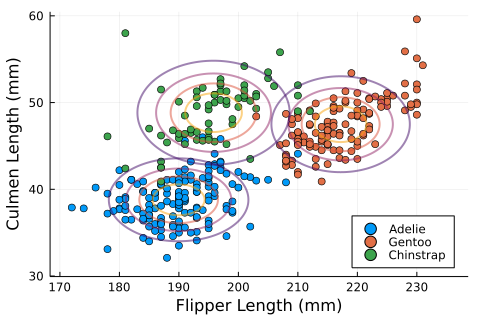

In [34]:
scatterplot(df, var1, var2)

for species in hypos
    contour!(joint_map[species], alpha=0.5)
end
plot!()

## Multivariate Normal Distribution

In [35]:
features = dropmissing(df[!, [var1, var2]]); # get rid of missing data

In [36]:
μ = mean.(eachcol(features))
μ

2-element Vector{Float64}:
 200.91520467836258
  43.9219298245614

In [37]:
Σ = cov(features) # defined in empiricaldist
covdf(features) # just to display the matrix

,index,Flipper Length (mm),Culmen Length (mm)
,String,Float64,Float64
1,Flipper Length (mm),197.732,50.3758
2,Culmen Length (mm),50.3758,29.8071


In [38]:
multinorm = MvNormal(μ, Σ);

In [39]:
"""Make a map from each species to a multivariate normal."""
function make_multinorm_map(df, colnames)
    multinorm_map = Dict()
    grouped = groupby(df, "Species2")
    for (k, group) in pairs(grouped)
        species = k[1]
        features = dropmissing(group[!, colnames])
        μ = mean.(eachcol(features))
        Σ = cov(features)
        multinorm_map[species] = MvNormal(vec(μ), Σ)
    end
    return multinorm_map
end

make_multinorm_map

In [40]:
multinorm_map = make_multinorm_map(df, [var1, var2]);

## Visualizing a Multivariate Normal Distribution

In [41]:
norm1 = flipper_map["Adelie"]
norm2 = culmen_map["Adelie"]
multinorm = multinorm_map["Adelie"];

In [42]:
pmf1 = make_pmf_norm(norm1)
pmf2 = make_pmf_norm(norm2);

In [43]:
densities = [pdf(multinorm, [x, y]) for y in pmf2.qs, x in pmf1.qs];
size(densities)

(101, 101)

In [44]:
joint = JointDistribution(densities, pmf2.qs, pmf1.qs)
normalize!(joint)

15.871343639913814

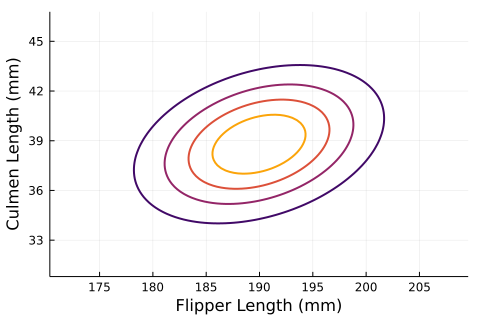

In [45]:
contour(joint)
xlabel!(var1)
ylabel!(var2)

In [46]:
"""Make a joint distribution.

norm1: `norm` object representing the distribution of the first feature
norm2: `norm` object representing the distribution of the second feature
multinorm: `multivariate_normal` object representing the joint distribution
"""
function make_joint(norm1, norm2, multinorm)
    # we don't need to go through Pmf
    sigmas = 3
    n = 101
    μ₁, σ₁ = mean(norm1), std(norm1)
    μ₂, σ₂ = mean(norm2), std(norm2)
    X = range(μ₁ - sigmas * σ₁, μ₁ + sigmas * σ₁, length=n)
    Y = range(μ₂ - sigmas * σ₂, μ₂ + sigmas * σ₂, length=n)
    
    densities = [pdf(multinorm, [x,y]) for y in Y, x in X]
    return JointDistribution(densities, Y, X)
end

make_joint

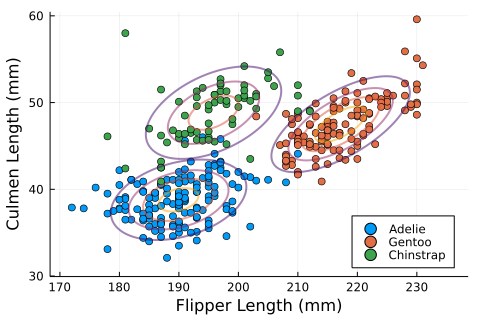

In [47]:
scatterplot(df, var1, var2)

for species in hypos
    norm1 = flipper_map[species]
    norm2 = culmen_map[species]
    multinorm = multinorm_map[species]
    joint = make_joint(norm1, norm2, multinorm)
    contour!(joint, alpha=0.5)
end
plot!()

## A Less Naive Classifier

In [48]:
"""Update hypothetical species."""
function update_penguin(prior, data, norm_map)
    hypos = prior.qs
    likelihood = [pdf(norm_map[hypo],data) for hypo in hypos]
    posterior = prior .* likelihood
    normalize!(posterior)
    return posterior
end

update_penguin

In [49]:
data = [193, 48]
update_penguin(prior, data, multinorm_map)

┌───────────┬────────────┐
│           │      probs │
├───────────┼────────────┤
│    Adelie │ 0.00274024 │
│    Gentoo │ 3.14808e-6 │
│ Chinstrap │   0.997257 │
└───────────┴────────────┘


In [50]:
df[!, "Classification"] .= missing
transform!(df, 
    AsTable(colnames) =>
        ByRow(data_seq -> all(ismissing, data_seq) ? missing :
                argmax(update_penguin(prior, collect(data_seq), multinorm_map))) => "Classification");

In [51]:
accuracy(df)

0.9532163742690059

## Summary

## Exercises

In [52]:
# Solution

# Here are the norm maps for the other two features

depth_map = make_norm_map(df, "Culmen Depth (mm)")
mass_map = make_norm_map(df, "Body Mass (g)");

In [53]:
# Solution

# And here are sequences for the features and the norm maps

colnames4 = ["Culmen Length (mm)", "Flipper Length (mm)", 
             "Culmen Depth (mm)", "Body Mass (g)"]
norm_maps4 = [culmen_map, flipper_map, 
              depth_map, mass_map];

In [54]:
# Solution

# Now let's classify and compute accuracy.

# We can do a little better with all four features,
# almost 97% accuracy

df[!, "Classification"] .= missing
transform!(df, 
    AsTable(colnames4) =>
        ByRow(data_seq -> all(ismissing, data_seq) ? missing :
                maxprob(update_naive(prior, data_seq, norm_maps4))) => "Classification");

accuracy(df)

0.9678362573099415

In [55]:
# Solution

gentoo = filter("Species2" => ==("Gentoo"), df)
subset = copy(gentoo);

In [56]:
combine(groupby(subset, "Sex"), nrow)

,Sex,nrow
,String?,Int64
1,MALE,61
2,FEMALE,58
3,missing,5


In [57]:
combine(groupby(df, "Sex"), nrow) # no Sex=="."...

,Sex,nrow
,String?,Int64
1,MALE,168
2,FEMALE,165
3,missing,11


In [58]:
valid = filter("Sex" => !ismissing, df)
nrow(valid)

333

In [59]:
subset = filter("Sex" => !ismissing, gentoo);

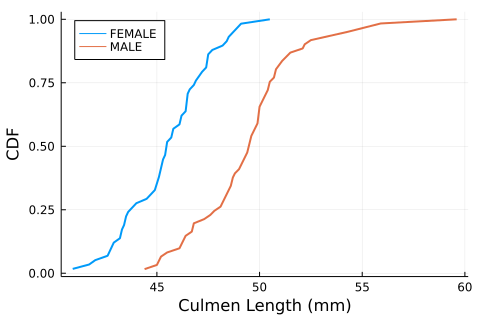

In [60]:
# Solution

# Here are the feature distributions grouped by sex

plot_cdfs(subset, "Culmen Length (mm)", "Sex")

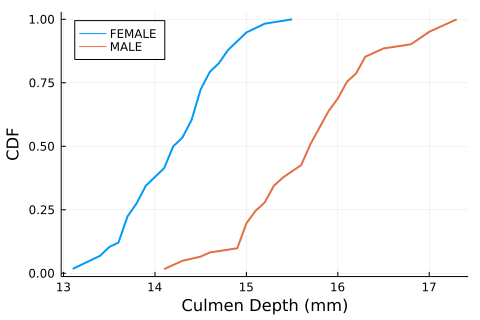

In [61]:
# Solution

plot_cdfs(subset, "Culmen Depth (mm)", "Sex")

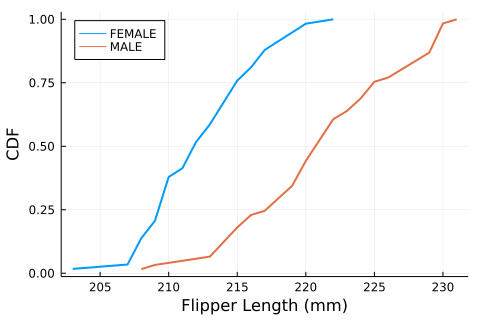

In [62]:
# Solution

plot_cdfs(subset, "Flipper Length (mm)", "Sex")

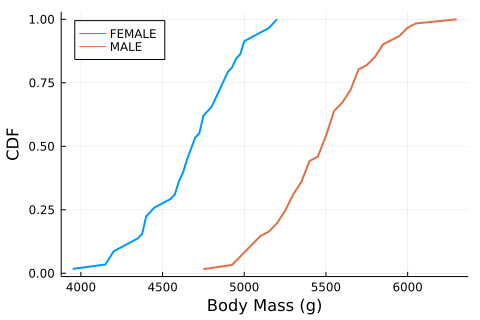

In [63]:
# Solution

plot_cdfs(subset, "Body Mass (g)", "Sex")

In [64]:
# Solution

# Here are the norm maps for the features, grouped by sex

culmen_map = make_norm_map(subset, "Culmen Length (mm)", by="Sex")
flipper_map = make_norm_map(subset, "Flipper Length (mm)", by="Sex")
depth_map = make_norm_map(subset, "Culmen Depth (mm)", by="Sex")
mass_map = make_norm_map(subset, "Body Mass (g)", by="Sex");

In [65]:
# Solution

# And here are the sequences we need for `update_naive`

norm_maps4 = [culmen_map, flipper_map, depth_map, mass_map]
colnames4 = ["Culmen Length (mm)", "Flipper Length (mm)", 
             "Culmen Depth (mm)", "Body Mass (g)"];

In [66]:
# Solution

# Here's the prior

hypos = keys(culmen_map)
prior = Pmf(1/2, hypos)
prior

┌────────┬───────┐
│        │ probs │
├────────┼───────┤
│ FEMALE │   0.5 │
│   MALE │   0.5 │
└────────┴───────┘


In [67]:
# Solution

# And the update

subset[!, "Classification"] .= missing

transform!(subset, 
    AsTable(colnames4) =>
        ByRow(data_seq -> all(ismissing, data_seq) ? missing : # propagate missing
                maxprob(update_naive(prior, data_seq, norm_maps4))) => "Classification");

In [68]:
# Solution

# This function computes accuracy

"""Compute the accuracy of classification.

Compares columns Classification and Sex

df: DataFrame
"""
function accuracy_sex(df)
    nvalid = count(!ismissing, df[!, "Classification"])
    nsame = count(skipmissing(df[!, "Sex"] .== df[!, "Classification"]))
    return nsame / nvalid
end

accuracy_sex

In [69]:
# Solution

# Using these features we can classify Gentoo penguins by
# sex with almost 92% accuracy

accuracy_sex(subset)

0.9495798319327731

In [70]:
# Solution

# Here's the whole process in a function so we can
# classify the other species

"""
Run the whole classification process.

subset: DataFrame
"""
function classify_by_sex(subset)
    culmen_map = make_norm_map(subset, "Culmen Length (mm)", by="Sex")
    flipper_map = make_norm_map(subset, "Flipper Length (mm)", by="Sex")
    depth_map = make_norm_map(subset, "Culmen Depth (mm)", by="Sex")
    mass_map = make_norm_map(subset, "Body Mass (g)", by="Sex")

    norm_maps4 = [culmen_map, flipper_map, depth_map, mass_map]

    hypos = keys(culmen_map)
    prior = Pmf(1/2, hypos)

    subset[!, "Classification"] .= missing

    transform!(subset, 
        AsTable(colnames4) =>
            ByRow(data_seq -> all(ismissing, data_seq) ? missing : # propagate missing
                maxprob(update_naive(prior, data_seq, norm_maps4))) => "Classification")

    return accuracy_sex(subset)
end

classify_by_sex

In [71]:
# Solution

# Here's the subset of Adelie penguins

# The accuracy is about 88%

adelie = filter("Species2" => ==("Adelie"), df)
subset = copy(adelie)
classify_by_sex(subset)

0.9365079365079365

In [72]:
# Solution

# It looks like Gentoo and Chinstrap penguins are about equally
# dimorphic, Adelie penguins a little less so.

# All of these results are consistent with what's in the paper.